# Don't Overfit
Datasets like this are all about how to squeeze out the most info from the dataset without overfitting. And it is very very easy to overfit. The "Depression" column is unbalanced and most of the leaderboard scores are 90% + which means your final rank will be decided by a very handful of samples in the testcase which are tricky. That is why you should be careful about your validation mechanism.

If you liked the notebook, please leave an upvote!

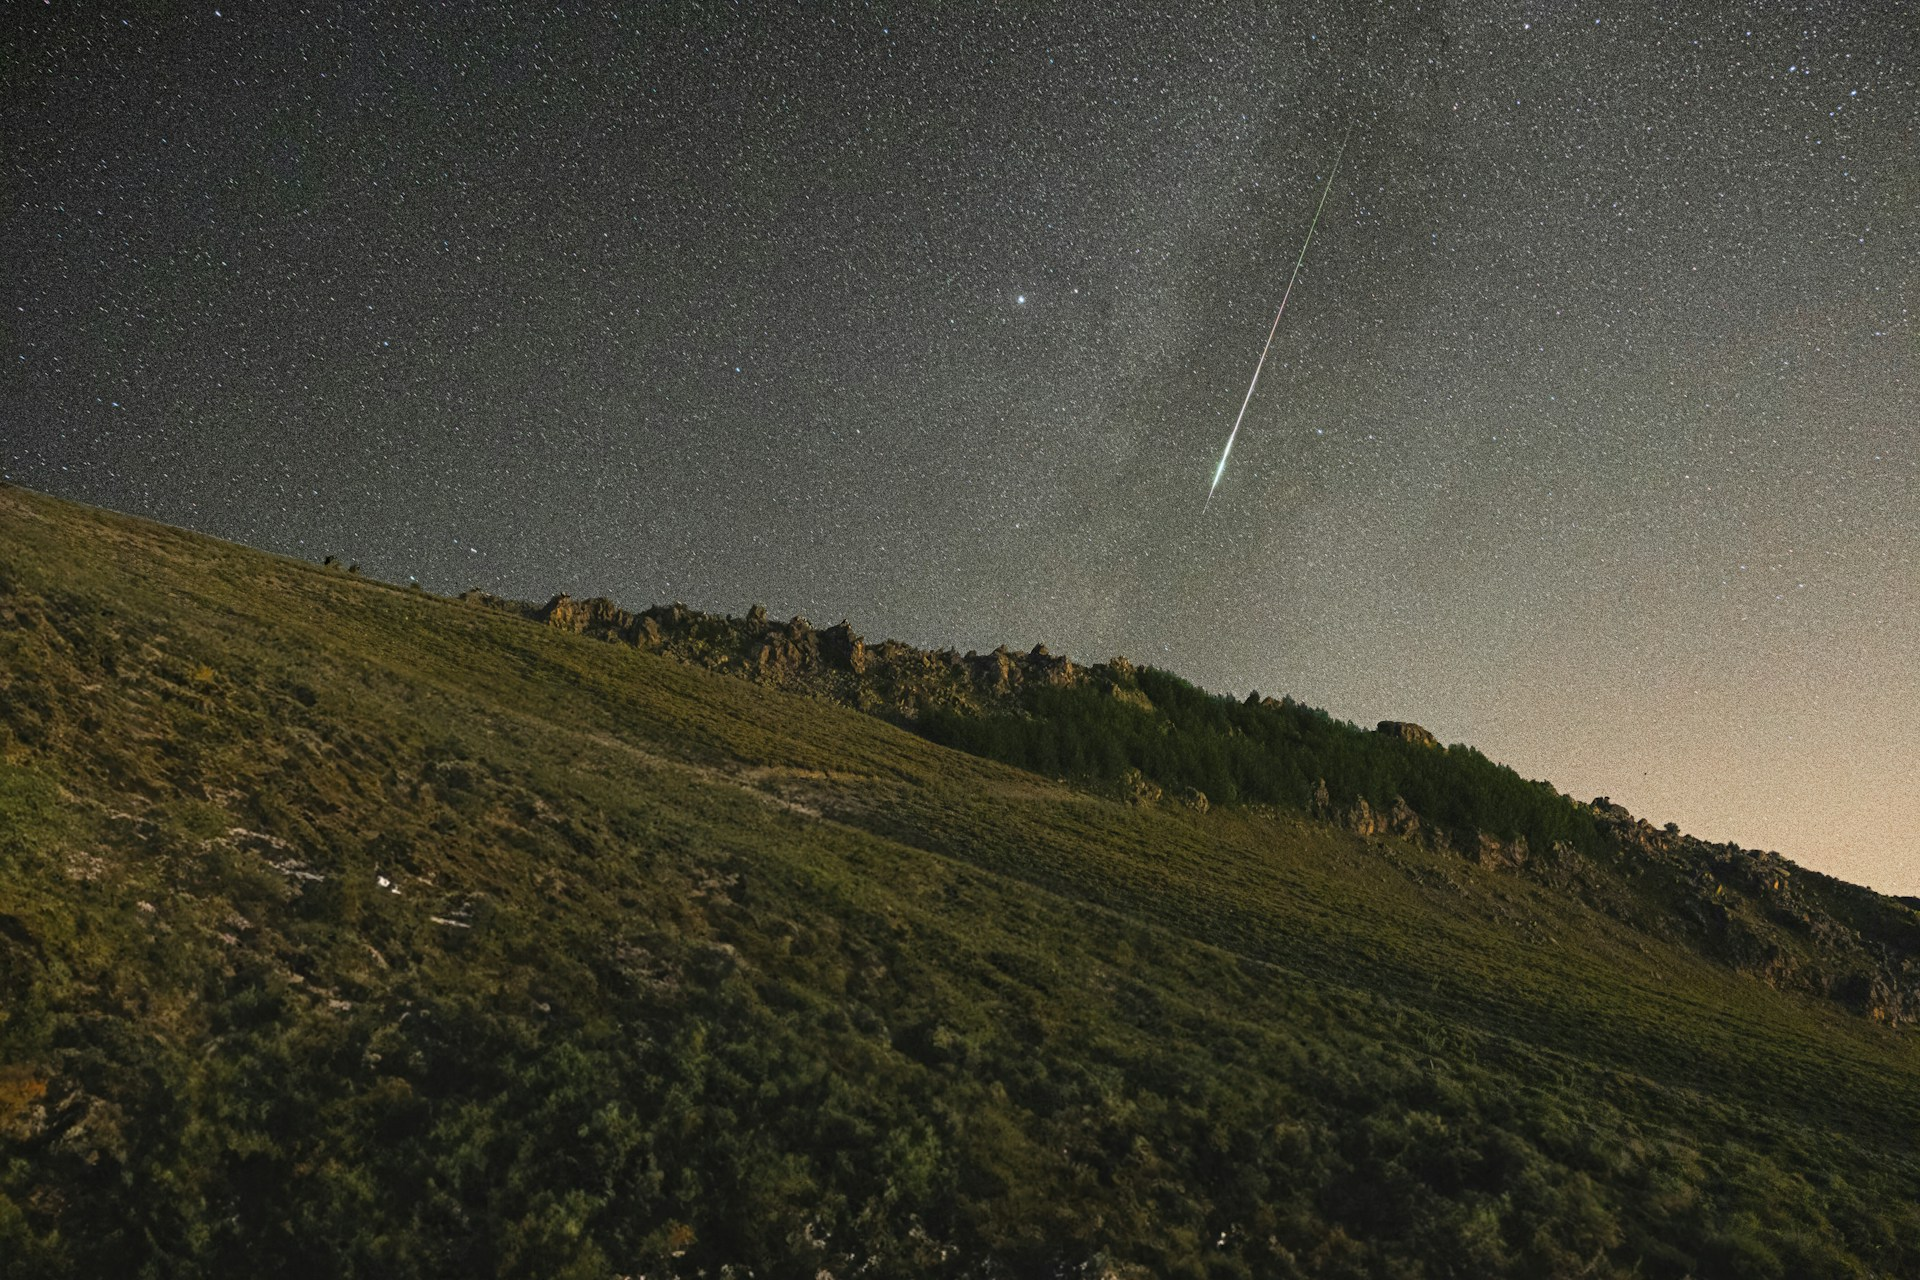

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import optuna
from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_FILE = "/kaggle/input/playground-series-s4e11/train.csv"
TEST_FILE = "/kaggle/input/playground-series-s4e11/test.csv"
SEED = 42
N_TRIALS = 40

# Data Cleaning and Formatting
We'll combine the train and test datasets and do the preprocessing on the combined dataset. It's much easier and simpler this way.

In [3]:
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)
train_y = train["Depression"]
n_train, n_test = train.shape[0], test.shape[0]

df = pd.concat([train, test])
df.head(10)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0.0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1.0
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1.0
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1.0
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0.0
5,5,Vani,Female,59.0,Ahmedabad,Working Professional,Finanancial Analyst,NaN,2.0,NaN,NaN,5.0,5-6 hours,Healthy,MCA,No,7.0,5.0,No,0.0
6,6,Ritvik,Male,47.0,Thane,Working Professional,Chemist,NaN,5.0,NaN,NaN,2.0,7-8 hours,Moderate,MD,No,6.0,2.0,No,0.0
7,7,Rajveer,Male,38.0,Nashik,Working Professional,Teacher,NaN,3.0,NaN,NaN,4.0,7-8 hours,Unhealthy,B.Pharm,No,10.0,3.0,Yes,0.0
8,8,Aishwarya,Female,24.0,Bangalore,Student,NaN,2.0,NaN,5.90,5.0,NaN,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0.0
9,9,Simran,Female,42.0,Patna,Working Professional,Electrician,NaN,4.0,NaN,NaN,1.0,5-6 hours,Healthy,ME,Yes,7.0,2.0,Yes,0.0


In [4]:
# Some column names are too big
df = df.rename(columns={
    "Have you ever had suicidal thoughts ?": "Suicidal Thoughts",
    "Family History of Mental Illness": "Family History",
})

# The Working Professional or Student column is redundant so we'll
# move the "Student" data points to the Profession column
df.loc[df["Working Professional or Student"] == "Student", "Profession"] = "Student"
df["CGPA"].fillna(-1, inplace=True)

# Academic Presssure and Study Satisfaction are only available for Students
# We can merge them with Work Pressure and Job Satisfaction
df["Work Pressure"].fillna(df["Academic Pressure"], inplace=True)
df["Job Satisfaction"].fillna(df["Study Satisfaction"], inplace=True)

# Let's designate all professions, cities and degrees which have less than 5 samples to "Other"
profession_counts = df["Profession"].value_counts()
rare_professions = profession_counts[profession_counts < 5].index
df["Profession"] = df["Profession"].replace(rare_professions, 'Other')

city_counts = df["City"].value_counts()
rare_cities = city_counts[city_counts < 5].index
df["City"] = df["City"].replace(rare_cities, 'Other')

df["Degree"] = df["Degree"].astype("str")
degree_counts = df["Degree"].value_counts()
rare_degrees = degree_counts[degree_counts < 5].index
df["Degree"] = df["Degree"].replace(rare_degrees, 'Other')

df["Masters_Degree"] = df["Degree"].apply(lambda x: x[0]=="M")

# The dataset is kinda unclean, we need to weed out non numerical values from supposedly numerical columns
df['Work/Study Hours'] = pd.to_numeric(df['Work/Study Hours'], errors='coerce')

# Also, convert 2 value columns into true binary columns
df["Family History"] = df["Family History"].map({"Yes": 1, "No": 0})
df["Suicidal Thoughts"] = df["Suicidal Thoughts"].map({"Yes": 1, "No": 0})
df["Gender"] = df["Gender"].map({"Female": 1, "Male": 0})
df['Dietary Habits'] = df['Dietary Habits'].map({
    "Unhealthy": -1,
    "Moderate": 0,
    "Healthy": 1,
})

# Sleep Duration has a bunch of differen values. Also we need to encode the values manually as any
# Encoder will not be able to properly encode these.
# We map the most common durations, the rest will be converted to nan, 
# which is fine since they are very few in number
df["Sleep Duration"] = df["Sleep Duration"].map({
    "3-4 hours": 4,
    "4-5 hours": 4,
    "Less than 5 hours": 4,
    "5-6 hours": 5,
    "6-7 hours": 6,
    "7-8 hours": 7,
    "More than 8 hours": 8
})

# We'll try to keep the Name column as per @HarshGupta's advice
# We'll remove the names which have less than 
name_counts = df["Name"].value_counts()
rare_names = name_counts[name_counts < 500].index
df["Name"] = df["Name"].replace(rare_names, 'Other')

# Removing the columns we have no use of now
df = df.drop(["id", "Working Professional or Student", "Academic Pressure", "Study Satisfaction"], axis=1).reset_index(drop=True)

In [5]:
# US salaries as per ChatGPT. Applies closely to the Indian market too.
# I have updated a few to bring it closer to an Indian parity.
salaries_by_prof = {
    'Chef': 60_000,
    'Teacher': 60_000,
    'Student': 0,
    'Business Analyst': 80_000,
    'Financial Analyst': 85_000,
    'Chemist': 75_000,
    'Electrician': 60_000,
    'Software Engineer': 130_000,
    'Data Scientist': 160_000,
    'Plumber': 55_000,
    'Marketing Manager': 95_000,
    'Accountant': 70_000,
    'Entrepreneur': 150_000,
    'HR Manager': 70_000,
    'UX/UI Designer': 85_000,
    'Content Writer': 60_000,
    'Educational Consultant': 65_000,
    'Civil Engineer': 90_000,
    'Manager': 110_000,
    'Pharmacist': 80_000,
    'Architect': 100_000,
    'Mechanical Engineer': 85_000,
    'Customer Support': 40_000,
    'Consultant': 90_000,
    'Judge': 150_000,
    'Researcher': 70_000,
    'Pilot': 200_000,
    'Graphic Designer': 50_000,
    'Travel Consultant': 45_000,
    'Digital Marketer': 70_000,
    'Lawyer': 120_000,
    'Research Analyst': 100_000,
    'Sales Executive': 60_000,
    'Doctor': 200_000,
    'Unemployed': 0,
    'Investment Banker': 250_000,
    'Other': 50_000,
    'Academic': 70_000,
    'Working Professional': 80_000
}
df["Salary"] = df["Profession"].map(salaries_by_prof)

In [6]:
# whether or not a job is an office based desk job.
office_based = {
    'Chef': False,
    'Teacher': False,
    'Student': False,
    'Business Analyst': True,
    'Financial Analyst': True,
    'Chemist': False,
    'Electrician': False,
    'Software Engineer': True,
    'Data Scientist': True,
    'Plumber': False,
    'Marketing Manager': True,
    'Accountant': True,
    'Entrepreneur': True,  # can be True too
    'HR Manager': True,
    'UX/UI Designer': True,
    'Content Writer': True,
    'Educational Consultant': True,
    'Civil Engineer': False,
    'Manager': True,
    'Pharmacist': False,
    'Architect': True,
    'Mechanical Engineer': False,
    'Customer Support': True,
    'Consultant': True,
    'Judge': False,
    'Researcher': True,
    'Pilot': False,
    'Graphic Designer': True,
    'Travel Consultant': True,
    'Digital Marketer': True,
    'Lawyer': False, # can be True too
    'Research Analyst': True,
    'Sales Executive': True,
    'Doctor': False,
    'Unemployed': False,
    'Investment Banker': True,
    'Other': False,
    'Academic': True,
    'Working Professional': True
}
df["Desk_Job"] = df["Profession"].map(office_based)

In [7]:
df.sample(10)

,Name,Gender,Age,City,Profession,Work Pressure,CGPA,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Suicidal Thoughts,Work/Study Hours,Financial Stress,Family History,Depression,Masters_Degree,Salary,Desk_Job
8792,Jiya,1,58.0,Chennai,NaN,4.0,-1.00,2.0,4.0,1.0,Class 12,0,3.0,5.0,1,0.0,False,NaN,NaN
191352,Satyam,0,24.0,Nashik,Teacher,2.0,-1.00,5.0,4.0,1.0,MBBS,0,2.0,4.0,1,NaN,True,60000.0,False
176934,Raghavendra,0,46.0,Kolkata,Teacher,3.0,-1.00,3.0,5.0,-1.0,B.Ed,0,7.0,5.0,0,NaN,False,60000.0,False
218102,Ivaan,0,25.0,Srinagar,Student,3.0,6.99,5.0,5.0,1.0,LLB,1,12.0,4.0,0,NaN,False,0.0,False
184222,Nikhil,0,47.0,Meerut,Sales Executive,5.0,-1.00,1.0,4.0,0.0,B.Com,0,1.0,4.0,1,NaN,False,60000.0,True
219305,Pratyush,0,25.0,Kalyan,Student,5.0,6.10,5.0,5.0,1.0,MBBS,0,9.0,5.0,1,NaN,True,0.0,False
162670,Aarti,1,30.0,Nagpur,Student,3.0,8.44,2.0,7.0,0.0,MCA,1,3.0,1.0,1,NaN,True,0.0,False
223422,Kriti,1,42.0,Jaipur,Consultant,4.0,-1.00,5.0,8.0,1.0,MCA,0,12.0,1.0,0,NaN,True,90000.0,True
101259,Arnav,0,20.0,Indore,NaN,5.0,-1.00,5.0,4.0,-1.0,Class 12,1,0.0,5.0,1,1.0,False,NaN,NaN
143493,Amit,0,18.0,Agra,NaN,3.0,-1.00,1.0,8.0,-1.0,Class 12,1,4.0,4.0,0,NaN,False,NaN,NaN


# Distribution of some of the basic fields
Since the data is a synthetic one, it seems the distribution is intentionally kept very even.

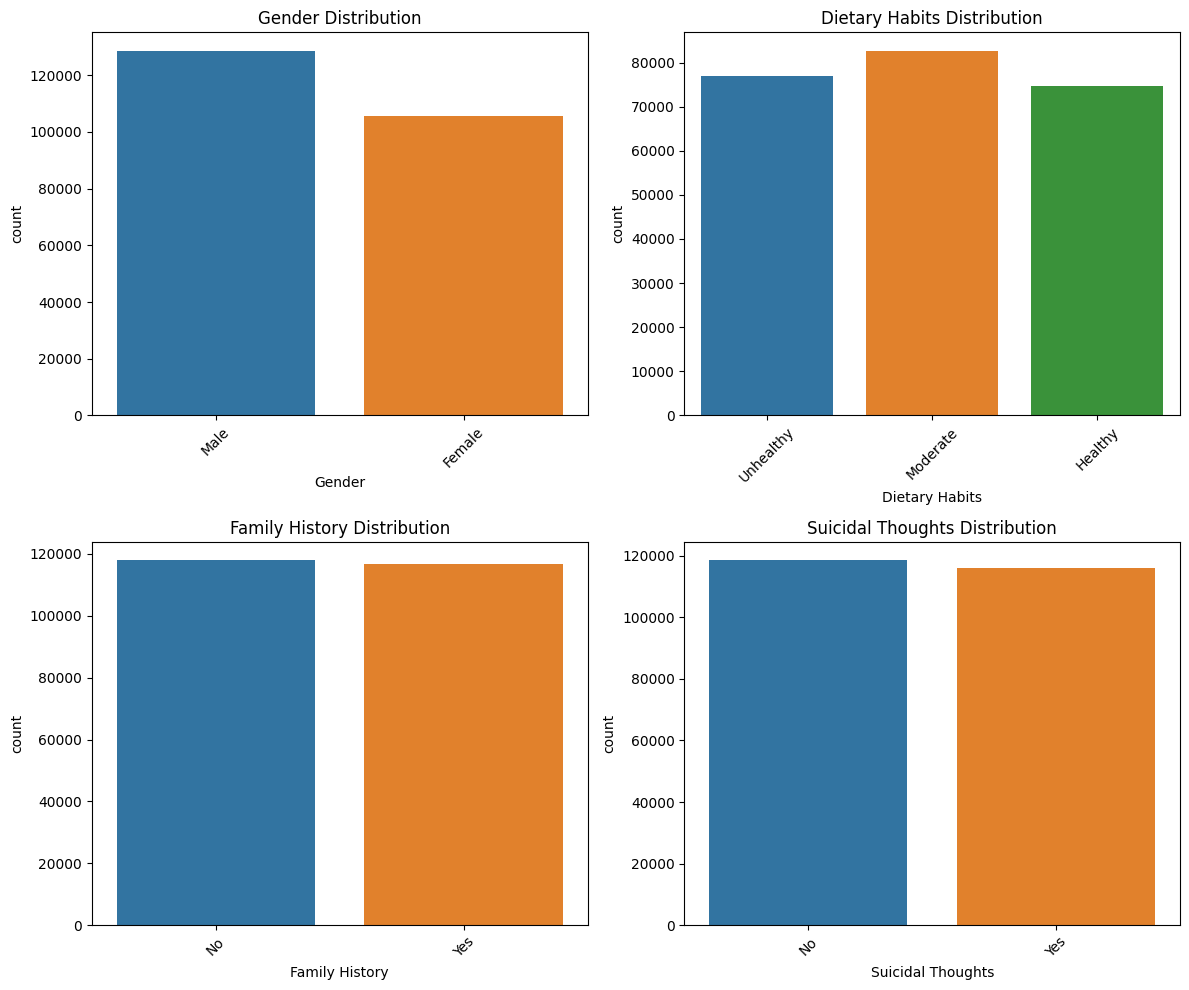

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns to plot and the tick labels
categorical_columns = ['Gender', 'Dietary Habits', 'Family History', 'Suicidal Thoughts']
custom_tick_labels = {
    'Gender': ['Male', 'Female'],
    'Dietary Habits': ['Unhealthy', 'Moderate', 'Healthy'],
    'Family History': ['No', 'Yes'],
    'Suicidal Thoughts': ['No', 'Yes']
}

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the columns and corresponding axes
for i, column in enumerate(categorical_columns):
    sns.countplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(f'{column} Distribution')
    axes[i].set_xticklabels(custom_tick_labels[column], rotation=45)  # Set custom tick labels

# Adjust layout
plt.tight_layout()
plt.show()

### We are going to try out 3 different kinds of models
- XGBoost
- CatBoost
- LGBM

In the previous versions of the Notebook, I tried Logistic Regression and Neural Network, but as expected, Tree based models are vastly superior for problems like this. So I'll be focusing on models in the tree family.

# Preprocessing

In [9]:
numerical_cols = ["Gender", "Age", "Work Pressure", "Job Satisfaction", "Sleep Duration", "Dietary Habits", "Suicidal Thoughts", "Work/Study Hours", "Financial Stress", "Family History", "Masters_Degree", "Salary", "Desk_Job"]
categorical_cols = ["Name", "City", "Profession", "Degree"]

In [10]:
# Separate features and target variable
X = df.drop(columns=['Depression'])
y = df['Depression']

num_imputer = SimpleImputer(strategy='median')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

X = pd.get_dummies(X, columns=categorical_cols, dtype='int', drop_first=True)

In [11]:
# train test split for the models
X_train, X_val, y_train, y_val = train_test_split(X.iloc[:n_train, :], train_y, test_size=0.075, random_state=SEED)

# XGBoost

In [12]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1.0),
        'random_state': SEED,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
    }
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)  
best_xgb_params = study.best_params

# best trial
print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Best Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2024-11-13 05:58:58,640] A new study created in memory with name: no-name-72ad31f0-5e26-4d44-ab61-62c40d636f75
[I 2024-11-13 05:59:11,994] Trial 0 finished with value: 0.9379323415142613 and parameters: {'n_estimators': 99, 'max_depth': 7, 'learning_rate': 0.038617976047341136, 'subsample': 0.5366188268053154, 'colsample_bytree': 0.664810136072083, 'gamma': 4.0085085345512885, 'reg_alpha': 0.30777732024756776, 'reg_lambda': 0.0008645965664338176}. Best is trial 0 with value: 0.9379323415142613.
[I 2024-11-13 05:59:21,739] Trial 1 finished with value: 0.8164502984933194 and parameters: {'n_estimators': 52, 'max_depth': 10, 'learning_rate': 0.007085803996498071, 'subsample': 0.5647488552573016, 'colsample_bytree': 0.5344481468181934, 'gamma': 1.737582238368689, 'reg_alpha': 0.0018112815464855245, 'reg_lambda': 0.009573495360877867}. Best is trial 0 with value: 0.9379323415142613.
[I 2024-11-13 05:59:30,392] Trial 2 finished with value: 0.8164502984933194 and parameters: {'n_estimators

Best trial:
Value: 0.940206576329006
Best Params:
n_estimators: 363
max_depth: 3
learning_rate: 0.09703832874875537
subsample: 0.8936088472802275
colsample_bytree: 0.8644398486623803
gamma: 4.97280629368695
reg_alpha: 0.157554770967231
reg_lambda: 0.3840438839119277


# CatBoost

In [13]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'Logloss',
        'eval_metric': 'Accuracy',
        'logging_level': 'Silent',
        'random_seed': SEED,
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0, early_stopping_rounds=50)
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS)
best_catb_params = study.best_params
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-11-13 06:18:58,325] A new study created in memory with name: no-name-62df1aec-7c2c-4209-bb2c-2174e70e0d08
[I 2024-11-13 06:19:01,430] Trial 0 finished with value: 0.9391642187055813 and parameters: {'iterations': 482, 'learning_rate': 0.3196328360213625, 'depth': 7, 'l2_leaf_reg': 8.18200292675159, 'bagging_temperature': 0.0667426063433949, 'random_strength': 0.8251173284777734, 'border_count': 127}. Best is trial 0 with value: 0.9391642187055813.
[I 2024-11-13 06:19:10,647] Trial 1 finished with value: 0.9386904197858429 and parameters: {'iterations': 752, 'learning_rate': 0.11392881777811677, 'depth': 12, 'l2_leaf_reg': 5.603992346850982, 'bagging_temperature': 0.4413741636950147, 'random_strength': 0.35587420789826885, 'border_count': 36}. Best is trial 0 with value: 0.9391642187055813.
[I 2024-11-13 06:19:14,142] Trial 2 finished with value: 0.9325310338292429 and parameters: {'iterations': 970, 'learning_rate': 0.007863987232275068, 'depth': 6, 'l2_leaf_reg': 8.07065249742

Best parameters: {'iterations': 667, 'learning_rate': 0.0208198081853322, 'depth': 7, 'l2_leaf_reg': 1.9901918298940497, 'bagging_temperature': 0.96077899039548, 'random_strength': 0.02139853952787732, 'border_count': 210}
Best accuracy: 0.9410594143845352


# LightGBM

In [14]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 5),
        'verbose': -1,
        'random_state': SEED
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    preds = (preds >= 0.5).astype(int)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS)
best_lgbm_params = study.best_params
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-11-13 06:23:45,015] A new study created in memory with name: no-name-995f1ec5-9e3f-47fe-afa8-a9880728955e
[I 2024-11-13 06:23:49,514] Trial 0 finished with value: 0.9351843077797782 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'learning_rate': 0.49782044416186705, 'feature_fraction': 0.6295491014984329, 'bagging_fraction': 0.6945590327475104, 'bagging_freq': 1, 'min_child_samples': 27, 'lambda_l1': 4.785695242926008, 'lambda_l2': 1.8429337638530536}. Best is trial 0 with value: 0.9351843077797782.
[I 2024-11-13 06:24:05,210] Trial 1 finished with value: 0.9400170567611106 and parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'learning_rate': 0.3337814556918303, 'feature_fraction': 0.9586137574783915, 'bagging_fraction': 0.8809233331495072, 'bagging_freq': 3, 'min_child_samples': 81, 'lambda_l1': 3.482122223073687, 'lambda_l2': 3.320851141418835}. Best is trial 1 with value: 0.9400170567611106.
[I 2024-11-13 06:24:16,553] Trial 2 finished with value: 0.9378

Best parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'learning_rate': 0.3649184880040441, 'feature_fraction': 0.5892576524466304, 'bagging_fraction': 0.9151565488944755, 'bagging_freq': 4, 'min_child_samples': 94, 'lambda_l1': 3.912110615245159, 'lambda_l2': 3.9318132790561524}
Best accuracy: 0.9403013361129536


# Ensemble Prediction (VotingClassifier CV)
Train the models on the whole data with the best params and then take a weighted average. Let's find out the best weight for the models and the threshold.

In [15]:
test = X.iloc[n_train:, :]
train = X.iloc[:n_train, :]

In [16]:
def get_trained_models(X, y):
    # LGBM
    lgbm_model = lgb.LGBMClassifier(**best_lgbm_params, verbose=-1)
    lgbm_model.fit(X_train, y_train)
    
    # XGBoost
    xgb_model = XGBClassifier(**best_xgb_params, random_state=SEED, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X, y)
    
    # CatBoost
    catb_model = CatBoostClassifier(**best_catb_params)
    catb_model.fit(X, y, verbose=0, early_stopping_rounds=50)
    return xgb_model, catb_model, lgbm_model

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
y_pred = np.zeros((test.shape[0], 5))

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    xgb, catb, lgbm = get_trained_models(X_train, y_train)
    voting_classifier = VotingClassifier(estimators=[
        ('xgb', xgb),
        ('cat', catb),
        ('lgb', lgbm)
    ], voting='soft', verbose=False)
    voting_classifier.fit(X_train, y_train)
    y_pred[:, fold] = voting_classifier.predict_proba(test)[:, 1]
    print(f"Fold {fold} done!")

y_pred = np.mean(y_pred, axis=1)

0:	learn: 0.6531020	total: 25.2ms	remaining: 16.8s
1:	learn: 0.6162157	total: 50.3ms	remaining: 16.7s
2:	learn: 0.5823241	total: 74.9ms	remaining: 16.6s
3:	learn: 0.5514924	total: 98.2ms	remaining: 16.3s
4:	learn: 0.5231633	total: 122ms	remaining: 16.2s
5:	learn: 0.4972863	total: 146ms	remaining: 16.1s
6:	learn: 0.4733947	total: 170ms	remaining: 16s
7:	learn: 0.4509944	total: 195ms	remaining: 16.1s
8:	learn: 0.4309877	total: 220ms	remaining: 16.1s
9:	learn: 0.4125614	total: 253ms	remaining: 16.6s
10:	learn: 0.3956642	total: 284ms	remaining: 17s
11:	learn: 0.3800708	total: 314ms	remaining: 17.1s
12:	learn: 0.3658126	total: 338ms	remaining: 17s
13:	learn: 0.3526286	total: 362ms	remaining: 16.9s
14:	learn: 0.3409125	total: 385ms	remaining: 16.7s
15:	learn: 0.3297082	total: 409ms	remaining: 16.7s
16:	learn: 0.3193016	total: 434ms	remaining: 16.6s
17:	learn: 0.3099054	total: 460ms	remaining: 16.6s
18:	learn: 0.3006340	total: 484ms	remaining: 16.5s
19:	learn: 0.2927467	total: 508ms	remaining

In [18]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")

ensemble_preds = (y_pred >= 0.5).astype(int)
sub["Depression"] = ensemble_preds
sub.to_csv("submission.csv", index=False)